In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [155]:
def read_prediction(path, prefix="__label__"):
    predictions = []
    probabilities = []
    
    file = open(path, 'r')
    for line in file:
        data = line.strip("\n").split(" ")
        cleaned = []
        
        for label in data[::2]:
            cleaned.append(label[len(prefix):])
        
        predictions.append(cleaned)
        probabilities.append(data[1::2])
    
    return np.array(predictions), np.array(probabilities).astype(np.float64)

In [145]:
def read_clusters(path):
    cluster = {}
    
    file = open(path, 'r')
    for line in file:
        data = line.strip("\n").split(" ")
        cluster[data[0]] = int(data[1])
    
    return cluster

In [146]:
def read_expected(path, prefix="__label__"):
    expected = []
    other = []
    
    file = open(path, 'r')
    for line in file:
        data = line.strip("\n").split()
        
        i = 0
        for d in data:
            if d[:len(prefix)] == prefix:
                label = d[len(prefix):]
                break
            i += 1           
        expected.append(label)
        
        if i == 0:
            other.append(data[2])
        else:
            other.append(data[0])
    
    return np.array(expected), np.array(other)

In [142]:
cluster = read_clusters("data/fb15k/clusters.txt")

In [156]:
y_pred, y_prob = read_prediction("data/fb15k/predictions.txt")

In [160]:
y_exp, x_exp = read_expected("data/ft_freebase_mtr100_mte100-test.txt")

In [91]:
# Hits@n metric based on the evaluation of Tim Dettmers (ConvE)
# (https://github.com/TimDettmers/ConvE/blob/master/evaluation.py)
def hits_threshold(predicted, probabilities, expected, threshold, verbose = True):
    assert \
        len(predicted) == len(probabilities) and len(predicted) == len(expected), \
        "All inputs should have same length but got {}, {}, {}.".format(len(predicted), len(probabilities), len(expected))
    
    hits = []
    for i in range(len(predicted)):
        is_hit = np.any(probabilities[i][np.nonzero(predicted[i] == expected[i])] > threshold)
        if verbose:
            print(i, is_hit)
        if is_hit:
            hits.append(1.0)
        else:
            hits.append(0.0)
    return np.mean(hits)

In [119]:
thresholds = np.arange(0, 0.1, 0.01)
precision = []
for t in thresholds:
    precision.append(hits_threshold(y_pred, y_prob, y_exp, t, False))

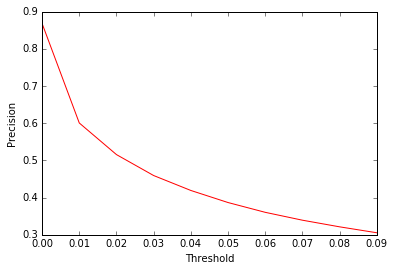

In [120]:
plt.plot(thresholds, precision, color='red')
plt.xlabel("Threshold")
plt.ylabel("Precision")

In [195]:
# Hits metric taking negative examples based on clustering into account
def hits_neg_threshold(predicted, probabilities, expected, expected_other, threshold, cluster, verbose = True):
    assert \
        len(predicted) == len(probabilities) and len(predicted) == len(expected), \
        "All inputs should have same length but got {}, {}, {}.".format(len(predicted), len(probabilities), len(expected))
    
    hits = []
    for i in range(len(predicted)):
        guess_indices = np.nonzero(probabilities[i] > threshold)
        guesses = predicted[i][guess_indices]
        is_hit = False
        has_miss = False
                
        for g in guesses:
            if g is expected[i]:
                is_hit = True
            if cluster[g] != cluster[expected_other[i]]:
                has_miss = True
            if has_miss and is_hit:
                break
        
        if verbose:
            print(i, is_hit)
            print(i, has_miss)
        if is_hit:
            hits.append(1.0)
        else:
            hits.append(0.0)
            
        if has_miss:
            hits.append(0.0)
        else:
            hits.append(1.0)
        
    return np.mean(hits)

In [196]:
thresholds = np.arange(0, 0.1, 0.01)
precision = []
for t in thresholds:
    precision.append(hits_neg_threshold(y_pred, y_prob, y_exp, x_exp, t, cluster, False))

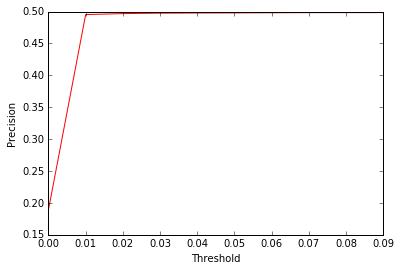

In [197]:
plt.plot(thresholds, precision, color='red')
plt.xlabel("Threshold")
plt.ylabel("Precision")

In [104]:
# TODO:
# Select negative samples from graph.
# Approaches:
# 1. Cluster the graph and select nodes pairs from to very different clusters – these should not appear in the data
# 2. Find nodes that never have an edge of some type

In [118]:
# Average probability among top 10
top_prob = y_prob[:, :10]
np.median(top_prob), np.mean(top_prob), np.max(top_prob), np.min(top_prob)

(0.0241295, 0.07042871778164919, 1.00001, 1e-05)

In [ ]:
y_prob.shape[1]

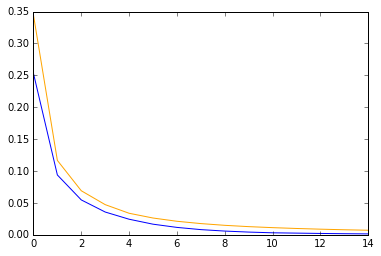

In [134]:
dims = 15
plt.plot(np.arange(dims), np.median(y_prob, axis=0)[:dims], color='blue')
plt.plot(np.arange(dims), np.mean(y_prob, axis=0)[:dims], color='orange')
plt.show()